In [110]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Chargement des données
data=pd.read_csv('diabetes.csv')

In [114]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [116]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [118]:
#Replace zero values with median for features like Glucose, BMI, etc.
zero_counts=(data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]==0).sum()

In [120]:
zero_counts

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [122]:
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[column] = data[column].replace(0, data[column][data[column] != 0].median())

In [124]:
zero_counts = (data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum()

In [126]:
zero_counts

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

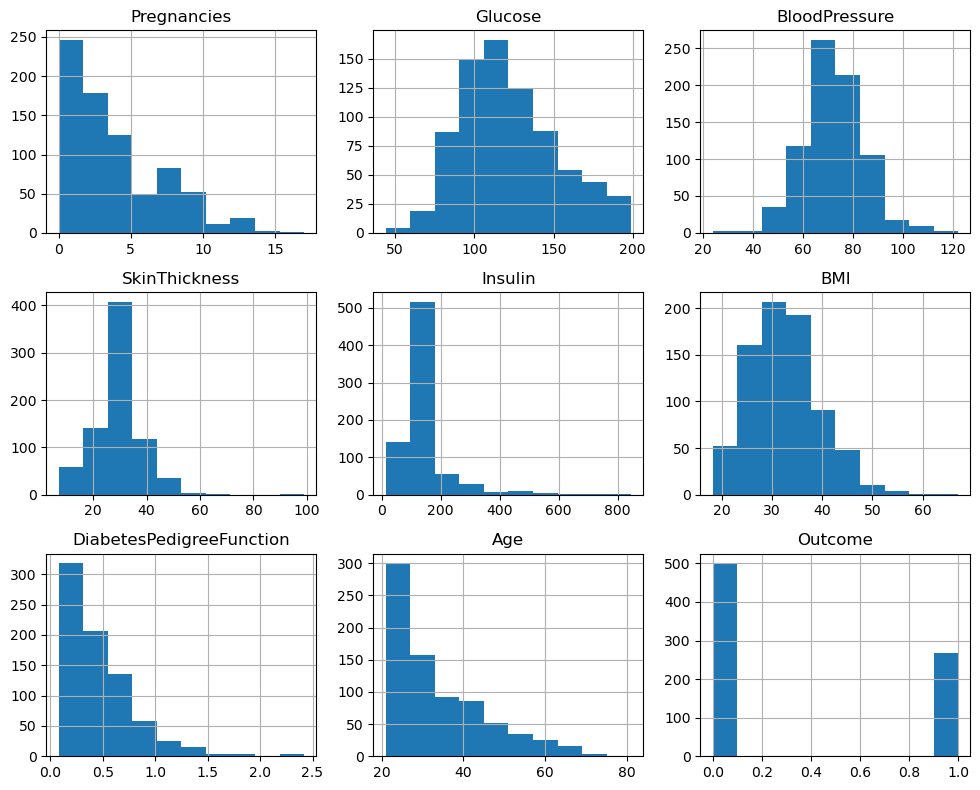

In [128]:
#Visualize feature distributions and correlations.
data.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

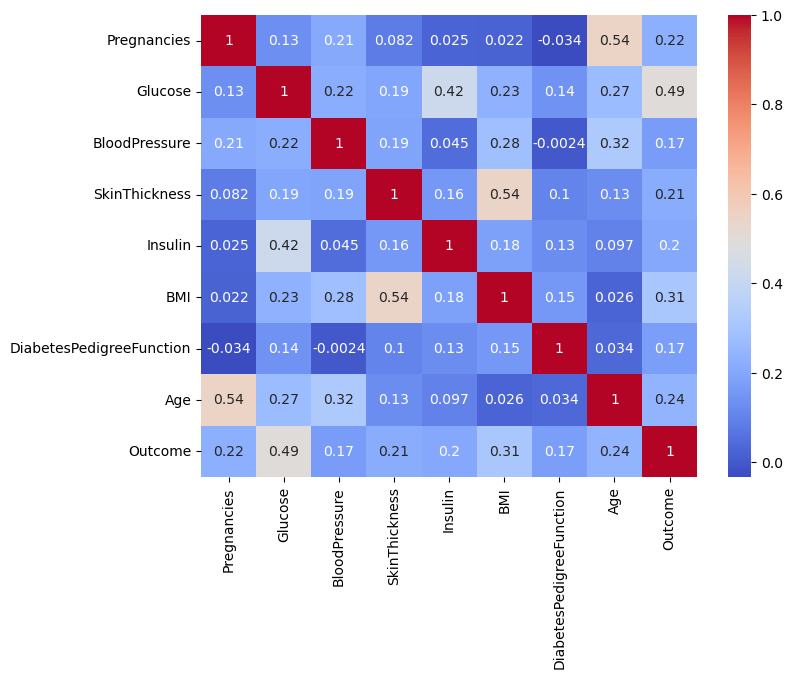

In [129]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

#  Fonctions d'activations et la classe MLP

In [132]:
# Fonctions d’activation
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    assert np.all((result >= 0) & (result <= 0.25)), "Sigmoid derivative must be in [0, 0.25]"
    return result

In [135]:
# Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes)
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) 
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1])
            assert b.shape == (1, layer_sizes[i+1])
            self.weights.append(w)
            self.biases.append(b)
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert X.shape[1] == self.layer_sizes[0]
        self.activations = [X]
        self.z_values = []

        A = X
        for i in range(len(self.weights) - 1):
            z = A @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1])
            self.z_values.append(z)
            A = relu(z)
            self.activations.append(A)

        z = A @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1])
        self.z_values.append(z)
        A = sigmoid(z)
        assert A.shape == (X.shape[0], self.layer_sizes[-1])
        self.activations.append(A)
        return A  
    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)
        assert y_true.shape == y_pred.shape
        assert np.all((y_true == 0) | (y_true == 1))
        eps = 1e-8
        loss = -np.mean(y_true * np.log(y_pred ) + (1 - y_true) * np.log(1 - y_pred ))
        assert not np.isnan(loss)
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)
        assert y_true.shape == y_pred.shape
        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1
        return accuracy
    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray)
        assert X.shape[1] == self.layer_sizes[0]
        assert y.shape == outputs.shape

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        self.d_weights[-1] = self.activations[-2].T @ dZ / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i+1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = self.activations[i].T @ dZ / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]
    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray)
        assert X.shape[1] == self.layer_sizes[0]
        assert y.shape[1] == self.layer_sizes[-1]
        assert X_val.shape[1] == self.layer_sizes[0]
        assert y_val.shape[1] == self.layer_sizes[-1]
        assert isinstance(epochs, int) and epochs > 0
        assert isinstance(batch_size, int) and batch_size > 0

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X = X[indices]
            y = y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)

            train_outputs = self.forward(X)
            val_outputs = self.forward(X_val)
            train_loss = self.compute_loss(y, train_outputs)
            val_loss = self.compute_loss(y_val, val_outputs)
            train_accuracy = self.compute_accuracy(y, train_outputs)
            val_accuracy = self.compute_accuracy(y_val, val_outputs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies
    def predict(self, X):
        assert isinstance(X, np.ndarray)
        assert X.shape[1] == self.layer_sizes[0]
        probs = self.forward(X)
        predictions = (probs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1])
        return predictions


In [137]:
# Préparation des données
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)

assert X.shape[0] == y.shape[0]
assert X.shape[1] == 8
# Standardisation : X = (X - mu) / sigma
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0]


In [139]:
# Création et entraînement du modèle
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.003)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=500, batch_size=32)

Epoch 0, Train Loss: 3.7849, Val Loss: 4.0706, Train Acc: 0.5601, Val Acc: 0.5041
Epoch 10, Train Loss: 1.2613, Val Loss: 1.4284, Train Acc: 0.6375, Val Acc: 0.5691
Epoch 20, Train Loss: 0.9209, Val Loss: 1.0174, Train Acc: 0.6802, Val Acc: 0.5935
Epoch 30, Train Loss: 0.7713, Val Loss: 0.8438, Train Acc: 0.7067, Val Acc: 0.6423
Epoch 40, Train Loss: 0.6884, Val Loss: 0.7445, Train Acc: 0.7210, Val Acc: 0.6748
Epoch 50, Train Loss: 0.6363, Val Loss: 0.6819, Train Acc: 0.7210, Val Acc: 0.6992
Epoch 60, Train Loss: 0.6032, Val Loss: 0.6415, Train Acc: 0.7251, Val Acc: 0.7236
Epoch 70, Train Loss: 0.5821, Val Loss: 0.6182, Train Acc: 0.7251, Val Acc: 0.7154
Epoch 80, Train Loss: 0.5653, Val Loss: 0.5992, Train Acc: 0.7251, Val Acc: 0.7236
Epoch 90, Train Loss: 0.5529, Val Loss: 0.5877, Train Acc: 0.7271, Val Acc: 0.7317
Epoch 100, Train Loss: 0.5428, Val Loss: 0.5798, Train Acc: 0.7373, Val Acc: 0.7317
Epoch 110, Train Loss: 0.5345, Val Loss: 0.5748, Train Acc: 0.7393, Val Acc: 0.7398
Epo

In [140]:
# Évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))


Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



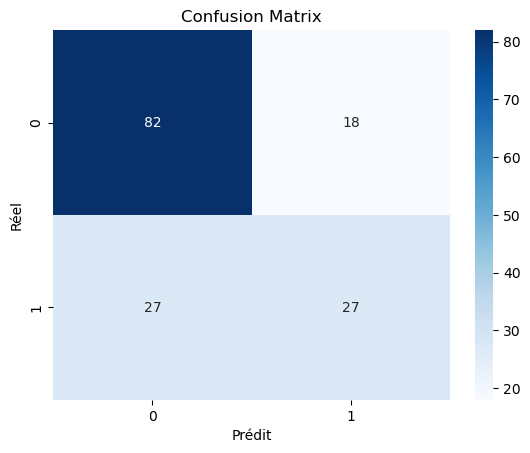

In [143]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

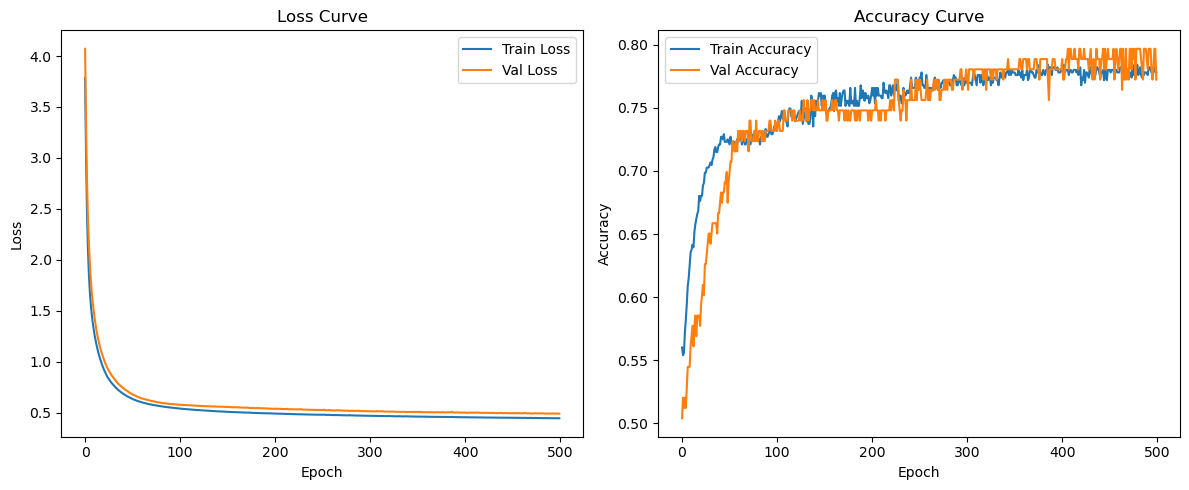

In [145]:
# Courbes de perte et d'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label="Train Loss")
ax1.plot(val_losses, label="Val Loss")
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(train_accuracies, label="Train Accuracy")
ax2.plot(val_accuracies, label="Val Accuracy")
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()